<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

## Get the data (PUBMED DATASET)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

In [6]:
def get_lines(filename):
  """
    Reads the file name and returns the
    lines of text as a list.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [8]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # Start of the new abstract
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [10]:
%%time
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


(180040, 30212, 30135)

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [13]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Encode Lables

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

In [17]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Create Baseline Model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using out baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-05 17:56:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-05 17:56:07 (19.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1
* Preparing data for deep sequence model
1. Create vectorization layer
2. Create embedding layers

In [25]:
from tensorflow.keras import layers

In [26]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [27]:
import matplotlib.pyplot as plt

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

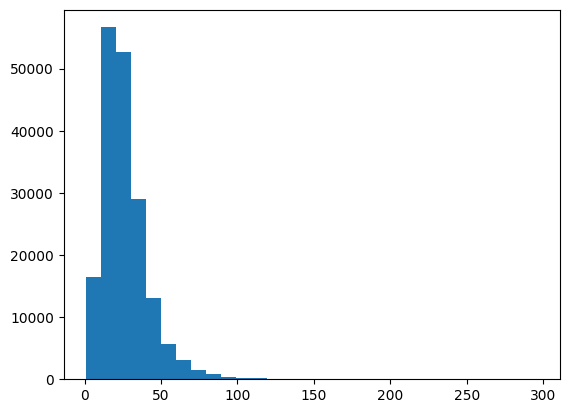

In [28]:
plt.hist(sent_lens, bins=30)

In [29]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# 95% of the sentences are under length 55

### Model 1: Text Vectorization (Tokenization)
* Tokenization is direct mapping from token to numbers

In [31]:
max_vocab_length = 68000 # max number of words to have in vocabulary
max_length = output_seq_len

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                               output_mode='int',
                                               output_sequence_length=max_length)

# Without adapt method or fitting the train_sentences the text_vectorization layer won't work
# On input sentences
train_vectorized = text_vectorizer.adapt(train_sentences)

In [32]:
import random
target_sentence = random.choice(train_sentences)
print(f"{len(target_sentence.split())}")
print(f"{target_sentence}")
x = text_vectorizer([target_sentence])
print(f"{x}")

20
in a subset of women , magnetic resonance imaging of the abdomen was performed to quantify abdominal fat volume .
[[   5    8 1941    4   90 1160 1390  688    4    2 4733   10  153    6
  3435  743  590  326    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
len(text_vectorizer.get_vocabulary())

64841

### Model 1: Text Embedding

In [34]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                                            output_dim=128,
                                            input_length=output_seq_len,
                                            mask_zero=True)

In [35]:
embedding_layer

In [36]:
y = embedding_layer(text_vectorizer([train_sentences[0]]))
y

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.04194263, -0.01005942,  0.03858415, ...,  0.04335061,
         -0.02013382,  0.02824414],
        [ 0.04233294, -0.04227885, -0.01155156, ...,  0.03131603,
         -0.02988199, -0.0414843 ],
        [-0.02918983, -0.0485836 , -0.00551844, ...,  0.04366574,
         -0.04100872,  0.02646505],
        ...,
        [-0.03738467,  0.02696705,  0.01119475, ...,  0.0077822 ,
          0.0019534 ,  0.03482361],
        [-0.03738467,  0.02696705,  0.01119475, ...,  0.0077822 ,
          0.0019534 ,  0.03482361],
        [-0.03738467,  0.02696705,  0.01119475, ...,  0.0077822 ,
          0.0019534 ,  0.03482361]]], dtype=float32)>

### Creating tensorflow datasets for model
* This loads the data faster because of tf dataset apis internal optimizations

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

### Create datasets into prefetched datasets

In [38]:
# Shuffle is not used here because we want to preserve the sequence of sentences for task
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Conv1D Model with token embedding

In [39]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/5
 44/562 [=>............................] - ETA: 45s - loss: 1.5087 - accuracy: 0.3224

In [ ]:
model_1.evaluate(val_dataset)

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

### Tensorflow Hub Pretrained Feature Extractor

In [46]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# Test our pretrained embeddings
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:30]}")

Random sentence: psoriasis causes worldwide concern because of its high-prevalence , as well as its harmful , and incurable characteristics .
Sentence after embedding: [-0.03665914  0.05359784 -0.03681412 -0.00502979 -0.00520678  0.03245135
 -0.00534571 -0.08303915  0.06665552 -0.00421127  0.0855794   0.04279539
 -0.00148906 -0.05530096 -0.00101606 -0.00367869 -0.08987782  0.00481205
  0.05452728  0.05994697  0.01251889  0.04269065  0.02439681  0.03744034
  0.05739767  0.02222268  0.01448711 -0.00868197  0.04559238  0.04125884]


In [48]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [49]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9171 - accuracy: 0.6482 - val_loss: 0.7966 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7679 - accuracy: 0.7022 - val_loss: 0.7540 - val_accuracy: 0.7061
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7512 - accuracy: 0.7112 - val_loss: 0.7374 - val_accuracy: 0.7134
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7184 - accuracy: 0.7232 - val_loss: 0.7101 - val_accuracy: 0.7264
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7249 - accuracy: 0.7214 - val_loss: 0.6897 - val_accuracy: 0.7367


In [ ]:
model_2.evaluate(val_dataset)

### Observe the trainable parameters in both models

In [ ]:
model_1.summary()

In [ ]:
model_2.summary()

In [53]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

945/945 [==============================] - 10s 11ms/step


array([[6.5467513e-01, 2.1460666e-01, 3.0872151e-03, 1.1975838e-01,
        7.8725414e-03],
       [4.8226926e-01, 4.2313251e-01, 6.8913489e-03, 8.5435353e-02,
        2.2714662e-03],
       [3.8408789e-01, 9.0499036e-02, 5.0587550e-02, 4.2456552e-01,
        5.0260011e-02],
       ...,
       [1.7848136e-03, 1.7266577e-03, 1.1590718e-01, 4.3625946e-04,
        8.8014507e-01],
       [2.6565334e-03, 1.8080246e-02, 4.7189295e-01, 8.6147839e-04,
        5.0650883e-01],
       [1.6943303e-01, 3.4946319e-01, 4.3224305e-01, 3.1850727e-03,
        4.5675736e-02]], dtype=float32)

In [ ]:
model_2_preds_probs.shape

In [55]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [56]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.40129749768303,
 'precision': 0.7310610734465771,
 'recall': 0.7340129749768304,
 'f1': 0.728289757715691}

## Conv1D with Character embeddings

In [57]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'p s o r i a s i s   c a u s e s   w o r l d w i d e   c o n c e r n   b e c a u s e   o f   i t s   h i g h - p r e v a l e n c e   ,   a s   w e l l   a s   i t s   h a r m f u l   ,   a n d   i n c u r a b l e   c h a r a c t e r i s t i c s   .'

In [58]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [59]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [60]:
chars_length = [len(sentence) for sentence in train_sentences]
mean_chars_length = np.mean(chars_length)
mean_chars_length

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

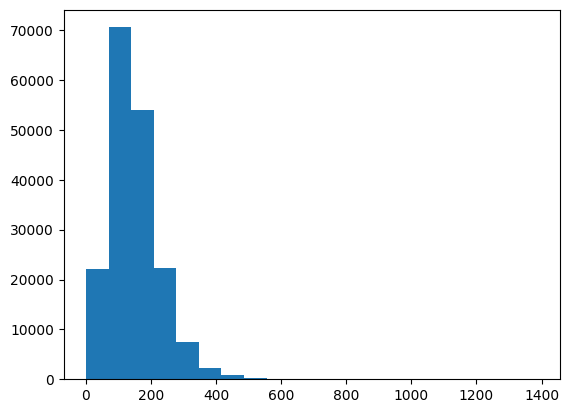

In [61]:
import matplotlib.pyplot as plt

plt.hist(chars_length, bins=20)

In [ ]:
output_seq_char_len = np.percentile(chars_length, 95)

In [63]:
output_seq_char_len

290.0

In [64]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
len(alphabet)

68

In [66]:
MAX_CHAR_TOKENS = len(alphabet) + 2 # for padding and unknown token
char_vectorizer = layers.TextVectorization(max_tokens=MAX_CHAR_TOKENS,
                                             output_sequence_length=int(output_seq_char_len),
                                             standardize="lower_and_strip_punctuation",
                                             name="char_vectorizer",
                                           )

In [67]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocabs = char_vectorizer.get_vocabulary()
print(x)

In [ ]:
char_vectorizer(random.choice(train_chars))

In [ ]:
len(char_vectorizer(random.choice(train_chars)))

In [ ]:
embedding_char = layers.Embedding(input_dim=len(char_vocabs),
                                  output_dim=25,
                                  mask_zero=False,
                                  name="char_embedding")

In [ ]:
x_embedding = embedding_char(char_vectorizer([random.choice(train_chars)]))

In [ ]:
x_embedding

### Model 3

In [74]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = embedding_char(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [76]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


history_model_3 = model_3.fit(train_char_dataset,
            epochs=5,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            validation_data=val_char_dataset,
            validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 5s 6ms/step - loss: 1.2875 - accuracy: 0.4831 - val_loss: 1.0846 - val_accuracy: 0.5814
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0349 - accuracy: 0.5831 - val_loss: 0.9650 - val_accuracy: 0.6230
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9558 - accuracy: 0.6239 - val_loss: 0.8868 - val_accuracy: 0.6629
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8980 - accuracy: 0.6471 - val_loss: 0.8556 - val_accuracy: 0.6705
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8832 - accuracy: 0.6571 - val_loss: 0.8259 - val_accuracy: 0.6888


In [ ]:
model_3.evaluate(val_dataset)

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [83]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [84]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.9733880577254,
 'precision': 0.6681250560006256,
 'recall': 0.669733880577254,
 'f1': 0.6642115648853382}

# Model 4 - Concat token-level embedding and character-level embedding

In [95]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu', name="token_output")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")

# 2. setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="char_output")(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

# 3. combine token model and character model by concatenation
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers adding in a dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [96]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

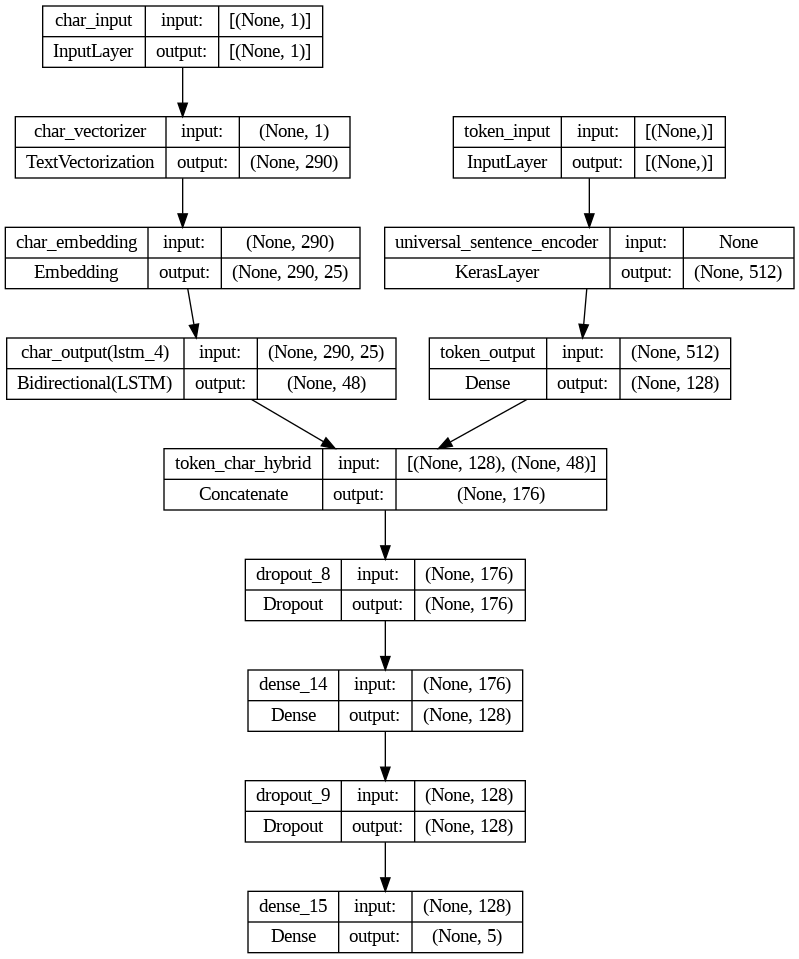

In [97]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [98]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_char_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [100]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 31s 42ms/step - loss: 0.9869 - accuracy: 0.6066 - val_loss: 0.7854 - val_accuracy: 0.6951
Epoch 2/5
562/562 [==============================] - 32s 57ms/step - loss: 0.8099 - accuracy: 0.6890 - val_loss: 0.7175 - val_accuracy: 0.7277
Epoch 3/5
562/562 [==============================] - 30s 54ms/step - loss: 0.7782 - accuracy: 0.7016 - val_loss: 0.6997 - val_accuracy: 0.7374
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7454 - accuracy: 0.7165 - val_loss: 0.6712 - val_accuracy: 0.7443
Epoch 5/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7511 - accuracy: 0.7120 - val_loss: 0.6562 - val_accuracy: 0.7493


In [101]:
model_4.evaluate(val_char_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6645 - accuracy: 0.7466


[0.6645368337631226, 0.7465576529502869]

In [102]:
model_4_pred_probs = model_4.predict(val_char_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[6.3019401e-01, 1.8127315e-01, 3.8842349e-03, 1.7842555e-01,
        6.2230197e-03],
       [3.7995180e-01, 4.8743194e-01, 8.6807162e-03, 1.1948839e-01,
        4.4470914e-03],
       [2.8522700e-01, 1.0066035e-01, 8.4839806e-02, 4.7636443e-01,
        5.2908361e-02],
       ...,
       [3.4646320e-04, 2.1500723e-03, 6.2670909e-02, 1.0813118e-04,
        9.3472445e-01],
       [5.9117964e-03, 2.5700297e-02, 4.1247436e-01, 2.4223006e-03,
        5.5349123e-01],
       [2.0211358e-01, 5.1978964e-01, 2.2526510e-01, 1.1078639e-02,
        4.1752972e-02]], dtype=float32)

In [103]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [104]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.65576592082617,
 'precision': 0.7446264061164614,
 'recall': 0.7465576592082617,
 'f1': 0.74143090910692}